In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import colors
import cartopy.crs as ccrs
import datetime as dt
import glob, os, sys
from matplotlib import animation
import matplotlib.path as mpath
import cartopy.feature as cfeature
import re
import os
import pandas as pd
import seaborn as sns
import math
import netCDF4 as nc
# np.set_printoptions(threshold=np.inf)

In [ ]:
base_path = '/gws/nopw/j04/asci/yixin/ftp.archive.arm.gov/dingy1/'# the path contains all instrument measurement 

# set empty list and dictionary
filelist = []
filedic = {}
numdic={}

#define time period
begin = 20161020
end = 20170224

#Reads the list of files and folders in the specified path
second_path = os.listdir(base_path)
for second in second_path:
    if '.' not in second:
        filedir = os.path.join(base_path,second)
        files = os.listdir(filedir)
        
        # use regular expressions to find number string indicate the measurment date
        for file in files:
            find_number = re.compile("\d{8}") 
            number = re.findall(find_number,file)
            
            # compare number string with target time period 
            if number:
                number = number[0]                
                if begin<=int(number)<=end and not filedic.get(file, False) and not numdic.get(number, False) :
                    filelist.append(os.path.join(filedir,file))


# <font color=blue>CLoud base height</font> 

In [ ]:
# set empty list
wacr_list = []
# use loop to append the file of target VAP
for i in filelist:
    if 'asiarsclwacr1kolliasM1'in i:
        wacr_list.append(i)        
wacr_list.sort() # sort in date order
print('wacr size is',len(wacr_list))
print(wacr_list[0],wacr_list[-1]) #print first and last datafile to check the measurment time

wacr size is 145
/gws/nopw/j04/asci/yixin/ftp.archive.arm.gov/dingy1/229920/asiarsclwacr1kolliasM1.c1.20161020.190000.custom.nc /gws/nopw/j04/asci/yixin/ftp.archive.arm.gov/dingy1/229920/asiarsclwacr1kolliasM1.c1.20170224.000000.custom.nc


In [4]:
# make empty arrays
wacr_array_base, wacr_time, wacr_array_base_qc, wacr_array_top_qc, wacr_array_top, wacr_array_top_qc_f, wacr_array_top_f, wacr_array_base_qc_1, wacr_array_base_1 = np.array([]), np.array([]), np.array([]),np.array([]), np.array([]),np.array([]), np.array([]),np.array([]), np.array([])

#read .nc files
for f in wacr_list:
    
    data_wacr = Dataset(f,'r')

    #extract variables
    data_base = data_wacr.variables['cloud_base_best_estimate'][:]
    data_base_qc = data_wacr.variables['qc_cloud_base_best_estimate'][:]
    data_top_f = data_wacr.variables['radar_first_top'][:]
    data_top_qc_f = data_wacr.variables['qc_radar_first_top'][:]

    wacr_data_time,time_unit=data_wacr.variables['time'][:],data_wacr.variables['time'].units
    data_time=nc.num2date(wacr_data_time,units=time_unit)# Convert the time format
    
    
    #append numpy array
    wacr_array_base = np.append(wacr_array_base,data_base)
    wacr_array_base_qc = np.append( wacr_array_base_qc,data_base_qc)
    wacr_array_top_f = np.append(wacr_array_top_f,data_top_f)
    wacr_array_top_qc_f = np.append( wacr_array_top_qc_f,data_top_qc_f)
    wacr_time = np.append(wacr_time,data_time)


print(np.shape(wacr_array_top_f)) 
print(np.shape(wacr_array_base))
print(np.shape(wacr_time))

(2505600,)
(2505600,)
(2505600,)


                        time cloud base base qc   cloud top top qc  month  \
2505316  2017-02-24 23:36:20      240.0     0.0  508.875244    0.0      2   
2505317  2017-02-24 23:36:25      240.0     0.0  508.875244    0.0      2   
2505318  2017-02-24 23:36:30      240.0     0.0  508.875244    0.0      2   
2505319  2017-02-24 23:36:35      230.0     0.0  508.875244    0.0      2   
2505320  2017-02-24 23:36:40      230.0     0.0  508.875244    0.0      2   

         months  
2505316  2017-2  
2505317  2017-2  
2505318  2017-2  
2505319  2017-2  
2505320  2017-2  
months
2016-10     899.376507
2016-11     834.962372
2016-12     985.381012
2017-1     1004.587236
2017-2     1132.573727
Name: cloud top, dtype: float64
months
2016-10    544.629320
2016-11    405.181483
2016-12    366.691544
2017-1     370.215596
2017-2     453.697292
Name: cloud base, dtype: float64
         months  month                 time base qc top qc      layer  \
1820871  2017-2      2  2017-02-24 23:36:20     0.0 

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


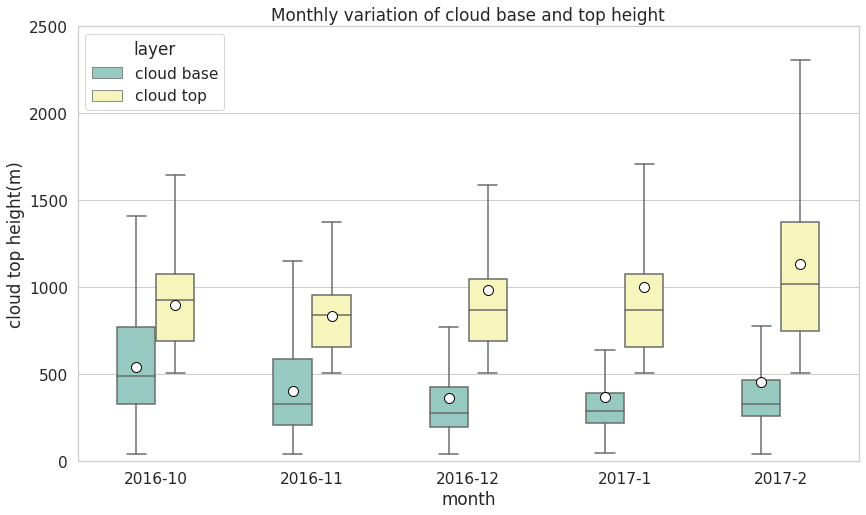

In [6]:
#stack 5 arrays along axis 1
top_array=np.stack((wacr_time, wacr_array_base, wacr_array_base_qc,wacr_array_top_f, wacr_array_top_qc_f), axis=1) 

# Convert NumPy Array to Pandas DataFrame
top_df = pd.DataFrame(top_array)

# define the columns name
top_df.columns = ['time','cloud base', 'base qc','cloud top', 'top qc']

# extract month imformation from time variables
top_df['month'] = top_df['time'].apply(lambda x: x.month)
#Add a year limit to prevent month order confusion
top_df['months'] = top_df['time'].apply(lambda x: str(x.year)+'-'+str(x.month))

# filter incorrect data by using 'qc' quality check
top_df = top_df.drop(top_df[(top_df['cloud top']== -9999.0)|(top_df['cloud top']<500)|(top_df['top qc']!=0)].index,axis = 0)
top_df_clear = top_df.drop(top_df[(top_df['cloud base']== -9999.0)|(top_df['cloud base']>2000)|(top_df['base qc']!=0)].index,axis = 0)

#print last 5 row
print(top_df_clear.tail(5))

# Group the data by month
grouped_top = top_df_clear.groupby('months')
print(top_df_clear.groupby('months')['cloud top'].mean())
print(top_df_clear.groupby('months')['cloud base'].mean())

# reshape the dataframe to fit seaborn boxplot format. id_vars : Column(s) to use as identifier variables; value_vars: Column(s) to unpivot.
top_melt=pd.melt(top_df_clear, id_vars=['months','month','time','base qc','top qc'], value_vars=['cloud base','cloud top'], var_name='layer', value_name='cloud height')
print(top_melt.tail(5))

# Plot the boxplot of cloud top and base
sns.set_theme(style="whitegrid",font='Times New Roman',font_scale=1.4)

f, ax = plt.subplots(figsize=(14, 8))
ax=sns.boxplot(x="months", y="cloud height", hue='layer',data=top_melt,width=0.5,palette="Set3",showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},showfliers = False)
ax.set(ylim=(0,2500), xlabel="month",
       ylabel="cloud top height(m)")
ax.set(title='Monthly variation of cloud base and top height')

#save the plot
plt.savefig('/home/users/ee21y2d/plot/cloud_t_b.png',format ='png', dpi=300)

# <font color=blue>lwp&cdnc</font> 

In [7]:
# set empty list
nd_list = []
# use loop to append the file of target VAP
for i in filelist:
    if 'asindropmfrsrM1'in i:
        nd_list.append(i)
        
nd_list.sort()# sort in date order
print('nd size is',len(nd_list))
print(nd_list[0],nd_list[-1]) #print first and last datafile to check the measurment time

nd size is 128
/gws/nopw/j04/asci/yixin/ftp.archive.arm.gov/dingy1/229920/asindropmfrsrM1.c1.20161020.000000.custom.nc /gws/nopw/j04/asci/yixin/ftp.archive.arm.gov/dingy1/229920/asindropmfrsrM1.c1.20170224.000000.custom.nc


In [16]:
# make empty arrays
nd_array_lwp, nd_time, nd_array_cdnc,nd_array_lwp_qc, nd_array_cdnc_qc = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

#read .nc files
for f in nd_list:
    
    data_nd = Dataset(f,'r')
    #extract variables
    nd_data_time,time_unit=data_nd.variables['time'][:],data_nd.variables['time'].units
    data_time=nc.num2date(nd_data_time,units=time_unit)# Convert the time format
    data_cdnc = data_nd.variables['drop_number_conc'][:]
    data_cdnc_qc = data_nd.variables['qc_drop_number_conc'][:]
    data_lwp = data_nd.variables['lwp_meas'][:]
    data_lwp_qc = data_nd.variables['qc_lwp_meas'][:]
    
    #append numpy array
    nd_array_lwp = np.append(nd_array_lwp,data_lwp)
    nd_array_lwp_qc = np.append(nd_array_lwp_qc,data_lwp_qc)
    nd_time = np.append(nd_time,data_time)
    nd_array_cdnc = np.append(nd_array_cdnc,data_cdnc)
    nd_array_cdnc_qc = np.append(nd_array_cdnc_qc,data_cdnc_qc)


                       time    cdnc cdnc_qc  month  months
552937  2017-02-24 23:58:20 -9999.0     3.0      2  2017-2
552938  2017-02-24 23:58:40 -9999.0     3.0      2  2017-2
552939  2017-02-24 23:59:00 -9999.0     1.0      2  2017-2
552940  2017-02-24 23:59:20 -9999.0     1.0      2  2017-2
552941  2017-02-24 23:59:40 -9999.0     3.0      2  2017-2
                       time        cdnc cdnc_qc  month  months
551943  2017-02-24 18:27:00  37203040.0     0.0      2  2017-2
551944  2017-02-24 18:27:20  97132400.0     0.0      2  2017-2
551945  2017-02-24 18:27:40  77423088.0     0.0      2  2017-2
551946  2017-02-24 18:28:00  76623384.0     0.0      2  2017-2
551948  2017-02-24 18:28:40  14743535.0     0.0      2  2017-2
months
2016-10    2.110205e+08
2016-11    1.471182e+08
2016-12    2.037692e+08
2017-1     2.560206e+08
2017-2     2.722368e+08
Name: cdnc, dtype: float64


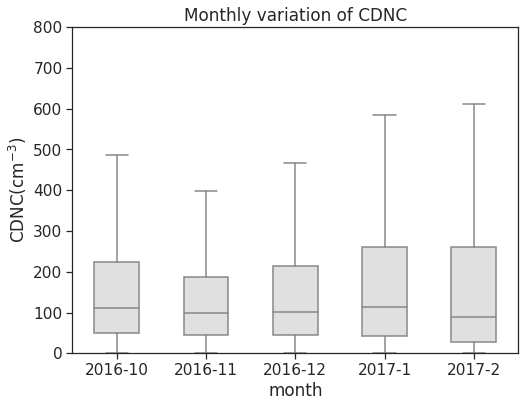

In [17]:
#stack time,cdnc and cdnc quality check arrays along axis 1
nd_array=np.stack((nd_time, nd_array_cdnc,nd_array_cdnc_qc), axis=1) 

# Convert NumPy Array to Pandas DataFrame
nd_df = pd.DataFrame(nd_array)
# define the columns name
nd_df.columns = ['time','cdnc','cdnc_qc']


# extract month imformation from time variables
nd_df['month'] = nd_df['time'].apply(lambda x: x.month)
#Add a year limit to prevent month order confusion
nd_df['months'] = nd_df['time'].apply(lambda x: str(x.year)+'-'+str(x.month))

# filter incorrect data by using 'qc' quality check
nd_df_clear = nd_df.drop(nd_df[(nd_df['cdnc']== -9999.0)|(nd_df['cdnc_qc']!=0)].index,axis = 0)

print(nd_df_clear.tail(5))

# Group the data by month
grouped_nd = nd_df_clear.groupby('months')
print(nd_df_clear.groupby('months')['cdnc'].mean())

#unit conversion from m-3 to cm-3
nd_df_clear['cdnc'] = nd_df_clear['cdnc']/1000000


# Plot the boxplot of CDNC
sns.set_theme(style="ticks",font='Times New Roman',font_scale=1.4)

f, ax = plt.subplots(figsize=(8, 6))
ax=sns.boxplot(x="months", y="cdnc", data=nd_df_clear,color='#E0E0E0',width=0.5,showfliers = False)
ax.set(ylim=(0,800), xlabel="month",
       ylabel="CDNC(cm$^{-3}$)")
ax.set(title='Monthly variation of CDNC')

#save the plot
plt.savefig('/home/users/ee21y2d/plot/cdnc.png',format ='png', dpi=300)

                       time       lwp lwp_qc  month  months
552937  2017-02-24 23:58:20   0.01232    0.0      2  2017-2
552938  2017-02-24 23:58:40  0.018236    0.0      2  2017-2
552939  2017-02-24 23:59:00  0.022936    0.0      2  2017-2
552940  2017-02-24 23:59:20  0.021018    0.0      2  2017-2
552941  2017-02-24 23:59:40  0.008746    0.0      2  2017-2
                       time       lwp lwp_qc  month  months
552937  2017-02-24 23:58:20   0.01232    0.0      2  2017-2
552938  2017-02-24 23:58:40  0.018236    0.0      2  2017-2
552939  2017-02-24 23:59:00  0.022936    0.0      2  2017-2
552940  2017-02-24 23:59:20  0.021018    0.0      2  2017-2
552941  2017-02-24 23:59:40  0.008746    0.0      2  2017-2
months
2016-10    0.141038
2016-11    0.207351
2016-12    0.213757
2017-1     0.186811
2017-2     0.166029
Name: lwp, dtype: float64


/opt/jaspy/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


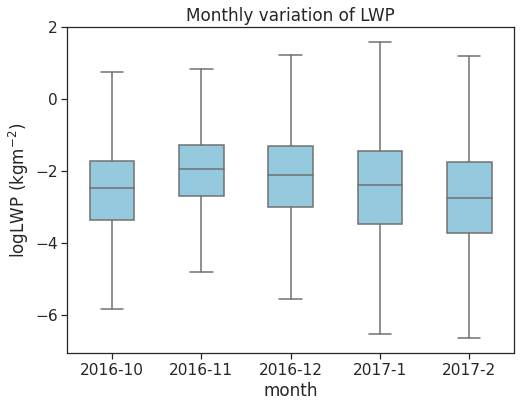

In [18]:
#stack time,lwp and lwp quality check arrays along axis 1
nd_array=np.stack((nd_time, nd_array_lwp,nd_array_lwp_qc), axis=1) 

# Convert NumPy Array to Pandas DataFrame
nd_df = pd.DataFrame(nd_array)
# define the columns name
nd_df.columns = ['time', 'lwp', 'lwp_qc']

# extract month imformation from time variables
nd_df['month'] = nd_df['time'].apply(lambda x: x.month)
#Add a year limit to prevent month order confusion
nd_df['months'] = nd_df['time'].apply(lambda x: str(x.year)+'-'+str(x.month))


# filter incorrect data by using 'qc' quality check
nd_df_clear = nd_df.drop(nd_df[(nd_df['lwp']== -9999.0)|(nd_df['lwp_qc']!=0)|(nd_df['lwp']==0)].index,axis = 0)

print(nd_df_clear.tail(5))

# Group the data by month
grouped_nd = nd_df_clear.groupby('months')

print(nd_df_clear.groupby('months')['lwp'].mean())

# calculate loglwp
nd_df_clear["lwp"] = np.log((nd_df_clear['lwp']).astype('float'))

# Plot the boxplot of CDNC
sns.set_theme(style="ticks",font='Times New Roman',font_scale=1.4)
f, ax = plt.subplots(figsize=(8, 6))
ax=sns.boxplot(x="months", y="lwp", data=nd_df_clear,color='SkyBlue',width=0.5,showfliers = False)
ax.set(xlabel="month",
       ylabel="logLWP (kgm$^{-2}$)")
ax.set(title='Monthly variation of LWP')

#save the plot
plt.savefig('/home/users/ee21y2d/plot/lwp.png',format ='png', dpi=300)


# <font color=blue>aerosol</font> 

In [8]:
# set empty list
aos_list = []
# use loop to append the file of target VAP
for i in filelist:
    if 'asiaosuhsasM1'in i:
        aos_list.append(i)
aos_list.sort()# sort in date order
print('aos size is',len(aos_list))
print(aos_list[0],aos_list[-1])#print first and last datafile to check the measurment time

aos size is 128
/gws/nopw/j04/asci/yixin/ftp.archive.arm.gov/dingy1/230265/asiaosuhsasM1.a1.20161020.000004.custom.nc /gws/nopw/j04/asci/yixin/ftp.archive.arm.gov/dingy1/230265/asiaosuhsasM1.a1.20170224.000005.custom.nc


In [9]:
# make empty arrays
aos_array_na, aos_time = np.array([]), np.array([])

#read .nc files
for f in aos_list:
    data_aos = Dataset(f,'r')
    
    #extract variables
    aos_na = np.sum(data_aos.variables['size_distribution'][:], axis=1)
    data_time,time_unit=data_aos.variables['time'][:],data_aos.variables['time'].units
    result=nc.num2date(data_time,units=time_unit)   
    
    #append numpy array
    aos_array_na = np.append(aos_array_na,aos_na)
    aos_time= np.append(aos_time,result)

print(np.shape(aos_array_na))
print(np.shape(aos_time)) 

(1096971,)
(1096971,)


                               time     Na   month
1096966  2017-02-24 23:59:18.479999  827.0  2017-2
1096967  2017-02-24 23:59:28.469999  843.0  2017-2
1096968  2017-02-24 23:59:38.479999  860.0  2017-2
1096969  2017-02-24 23:59:48.470001  848.0  2017-2
1096970  2017-02-24 23:59:58.479999  881.0  2017-2
month
2016-10    1784.596860
2016-11    1292.145903
2016-12    1288.920820
2017-1     1192.793252
2017-2     1354.647385
Name: Na, dtype: float64


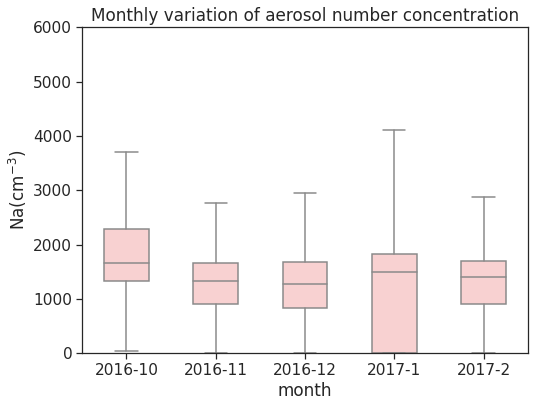

In [10]:
#stack time and aeresol concentration arrays along axis 1
aos_array=np.stack((aos_time, aos_array_na), axis=1) 

# Convert NumPy Array to Pandas DataFrame
aos_df = pd.DataFrame(aos_array)

# define the columns name
aos_df.columns = ['time','Na']

# extract month imformation from time variables. Add a year limit to prevent month order confusion
aos_df['month'] = aos_df['time'].apply(lambda x: str(x.year)+'-'+str(x.month))


# filter within reasonable range
aos_df_clear = aos_df.drop(aos_df[(aos_df['Na']<0)|(aos_df['Na']>5000)].index,axis = 0)

print(aos_df.tail(5))

# Group the data by month
grouped_aos = aos_df_clear.groupby('month')
print(aos_df_clear.groupby('month')['Na'].mean())


# Plot the boxplot of aerosol number concentration
sns.set_theme(style="ticks",font='Times New Roman',font_scale=1.4)

f, ax = plt.subplots(figsize=(8, 6))
ax=sns.boxplot(x="month", y="Na", data=aos_df_clear,color='#FFCACA',width=0.5, showfliers = False)
ax.set(ylim=(0,6000), xlabel="month",
       ylabel="Na(cm$^{-3}$)")
ax.set(title='Monthly variation of aerosol number concentration')

#save the plot
plt.savefig('/home/users/ee21y2d/plot/na.png',format ='png', dpi=300)